In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
import cnn_base as base
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil
from torchvision.datasets import ImageFolder
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
import time
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
import random

C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<font color='red'>https://developer.aliyun.com/article/1036530</font>

In [2]:
# 读取训练数据与测试数据，并转化为 NumPy 格式，方便后续实现自定义 Dataset。
train_data = pd.read_csv('../data/kaggle_leaves/classify-leaves/train.csv')
test_data = pd.read_csv('../data/kaggle_leaves/classify-leaves/test.csv')

train_images = train_data.iloc[:, 0].values
pred_images = test_data.iloc[:, 0].values
train_labels = pd.get_dummies(train_data.iloc[:, 1]).values.argmax(1)
train_labels_header = pd.get_dummies(train_data.iloc[:, 1]).columns.values

n_train = train_images.shape[0]

In [3]:
class CLASSIFY_LEAVES(torch.utils.data.Dataset):
    def __init__(self, root, images, labels, transform):
        # super(CLASSIFY_LEAVES, self).__init__()
        self.root = root
        self.images = images
        if labels is None:
            self.labels = None
        else:
            self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.root + self.images[index]
        image = Image.open(image_path)
        image = self.transform(image)
        if self.labels is None:
            return image
        label = torch.tensor(self.labels[index])
        return image, label

    def __len__(self):
        return self.images.shape[0]


def load_data(images, labels, batch_size, train):
    aug = []
    if train:
        aug = [transforms.RandomHorizontalFlip(),
               transforms.RandomVerticalFlip(),
               transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               transforms.ToTensor()]
    else:
        aug = [transforms.ToTensor()]
    transform = transforms.Compose(aug)
    dataset = CLASSIFY_LEAVES('../data/kaggle_leaves/classify-leaves/', images, labels, transform=transform)
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, shuffle=train)

In [4]:
def train_main(net, train_iter, test_iter, num_epochs, lr, num_gpus, out_dir):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    def accuracy(y_hat, y):
        return (y_hat.argmax(1) == y).sum()

    model_path = os.path.join(out_dir, 'cifar_%s.pth' % (num_epochs))
    result_csv_path = os.path.join(out_dir, 'train_detail_%s.csv' % num_epochs)
    print('model_path:', model_path)
    print('result_csv_path:', result_csv_path)
    net.apply(init_weights)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    #     trainer = torch.optim.SGD(net.parameters(), lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to(devices[0]), y.to(devices[0])
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()]
        # print('train_loss:', train_loss, '\ttrain_acc', test_acc, '\ttest_acc', test_acc)
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(result_csv_path, index=False)

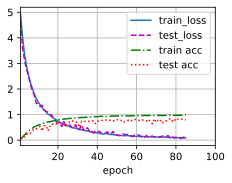

In [ ]:
train_slices = random.sample(list(range(n_train)), 15000)
test_slices = list(set(range(n_train)) - set(train_slices))
EPOCHS = 100

_train_iter = load_data(train_images[train_slices], train_labels[train_slices], 256, train=True)
_test_iter = load_data(train_images[test_slices], train_labels[test_slices], 256, train=False)
out_dir = '../data/kaggle_leaves/classify-leaves/save/'
# 训练。
train_main(torchvision.models.resnet18(num_classes=176), _train_iter, _test_iter, EPOCHS, 0.0001,
           1, out_dir)

In [ ]:
def predict(pred_iter):
    devices = [d2l.try_gpu(i) for i in range(1)]
    print(devices)
    net = torchvision.models.resnet18(num_classes=176)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net.load_state_dict(torch.load('../data/kaggle_leaves/classify-leaves/save/cifar_100.pth'))
    model = net.to('cuda:0')
    model.eval()  # 设置模型为推理模式
    # leaves_resnet_jupyter_baba_100
    net.to(torch.device('cuda:0'))
    net.eval()
    prediction = []
    for index, X in enumerate(pred_iter):
        X = X.to('cuda:0')
        prediction.extend(train_labels_header[net(X).argmax(1).cpu()])
    test_data['label'] = prediction
    test_data.to_csv('../data/kaggle_leaves/classify-leaves/save/submission.csv', index=None)

In [ ]:
predict(pred_iter=load_data(pred_images, None, 256, train=False))